# Стоимость жилья в РФ

## Разведочный анализ данных

<b> Анализ проводится с целью понять с какими данными собираемся работать, есть ли у них проверичивость, некорректность. В результате проведения анализа могут обнаружиться инсайты, которые укажут на слабые места датасета. </b>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from geopy.geocoders import Nominatim
from tqdm import tqdm

<b>Метаинформация информация о столбцах датасета.</b>

* price -  стоимость жилья
* date - дата объявления
* time - время объявления
* geo_lat - значение долготы дома
* geo_lon - значение широты дома
* region - регион
* building_type - тип зданий (0 - остальное, 1 - панель, 2 - монолит, 3 - камень, 4 - бетон, 5 - дерево)
* level - этаж
* levels - многоэтажность дома
* rooms - количество комнат
* area - площадь 
* kitchen_area - площадь кухни
* object_type - тип зданий (1 - перепродажа, 2 - новостройка)

In [2]:
data = pd.read_csv("all_v2.csv")

<b>Объединим дату и время объявлений с целью дальнейшего преобразования в timestamp и извлечения новый признаков.</b>

In [3]:
data["date_time"] = data["date"] + " " + data["time"]
data = data.drop(["date","time"],axis=1)

<b>В столбце Цена есть 356 значений с отрицательной стоимостью жилья, что в контексте данных не соотносится с логикой задачи. Поэтому удалим дубликаты и объекты недвижимости с отрицательной ценой.

Значение цены очень большое, при линейной регрессии будут искуственно завышать коэффициенты. Нужна нормализация (либо логарифмирование)</b>

In [4]:
data = data.loc[data["price"]>0]
data = data.drop_duplicates()

<b>Посмотрим первые 5 строчек датасета, чтобы понять с чем имеем дело. </b>

In [5]:
data.head()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,date_time
0,6050000,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1,2018-02-19 20:00:21
1,8650000,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1,2018-02-27 12:04:54
2,4000000,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1,2018-02-28 15:44:00
3,1850000,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11,2018-03-01 11:24:52
4,5450000,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1,2018-03-01 17:42:43


<b>Относительно мало данных о жилье. Есть несколько фичей о времени заявки, геопозиции дома, а также его общих характеристик. И только 3 признака описывающих именно недвижимость (и то все они вытекают из площади квартиры/дома). </b>

<b> Так как нам известны широта и долгота, можем определить местонахождение объекта. Из получаемого объекта можно взять разные данные: улицу, район, город, регион, округ. С целью отображения на графике возьмем город, т.е. state. </b>

In [6]:
# тк в датасете более 5 млн данных с целью оптимизации скрипта, будем вычислять адрес не по точной широте/долготе объекта,
# а по среднему значению для каждого региона. В данном случае нам это подходит, тк нам нужны крупные геоданные, 
# такие как округ/область, так что средняя широта/долгота по каждому объекту как раз даст нам нужный результат 
# при меньших затратах мощностей

lat_lon_data = data.groupby('region')['geo_lat','geo_lon'].mean()
lat_lon_data = lat_lon_data.reset_index()

latitude = list(map(str, lat_lon_data['geo_lat'].values))
longitude = list(map(str, lat_lon_data['geo_lon'].values))

geolocator = Nominatim(user_agent="geoapiExercises")

def get_location_name(latitude, longitude):
    state = []
    for lat, lon in tqdm(zip(latitude, longitude), total = len(latitude)):
        location = geolocator.reverse(lat+","+lon) # передаем широту/долготу
        address = location.raw['address'] # получаем словарь с данными
        state.append(address.get('state', ''))
    
    return state

state = get_location_name(latitude, longitude)
lat_lon_data['state'] = state

<ipython-input-6-cbfbe3ae9994>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  lat_lon_data = data.groupby('region')['geo_lat','geo_lon'].mean()
100%|██████████| 84/84 [00:42<00:00,  1.99it/s]


In [7]:
lat_lon_data.head()

,region,geo_lat,geo_lon,state
0,3,55.721558,37.577705,Москва
1,69,48.533577,132.798120,Еврейская автономная область
2,81,55.727234,37.784311,Москва
3,821,53.239632,34.294103,Брянская область
4,1010,56.917111,53.266262,Удмуртия


In [8]:
lat_lon_data[lat_lon_data['state'] == 'Санкт-Петербург']

,region,geo_lat,geo_lon,state
14,2661,59.932843,30.319591,Санкт-Петербург
29,3446,59.974242,30.458371,Санкт-Петербург


<b>Гистограмма распределения price показывает её смещение в правую сторону, а также наличие тяжелого правого хвоста. Распределение похоже на логнормальное. </b>

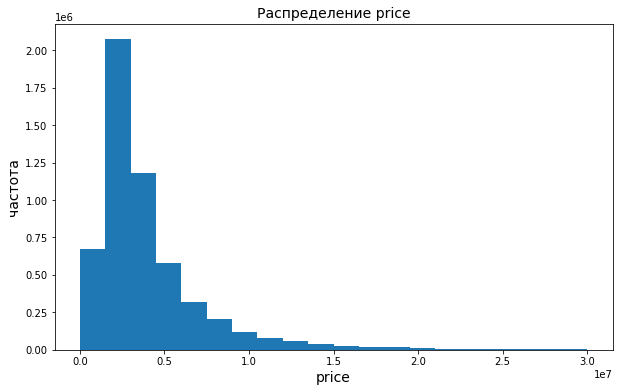

In [9]:
plt.figure(figsize=(10,6))
plt.hist(data["price"],range=(-1,30000000),bins=20)
plt.xlabel("price",fontsize=14)
plt.ylabel("частота",fontsize=14)
plt.title("Распределение price",fontsize=14);

<b> Логарифмирование приводит признак в нормально-подобный вид. </b>

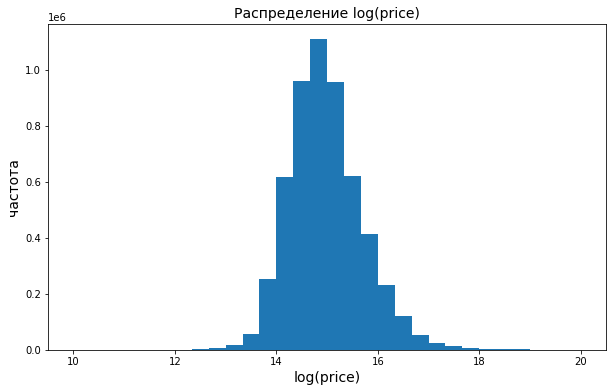

In [10]:
plt.figure(figsize=(10,6))
plt.hist(np.log(data.price),bins=30,range=(10,20))
plt.xlabel("log(price)",fontsize=14)
plt.ylabel("частота",fontsize=14)
plt.title("Распределение log(price)",fontsize=14);

<b>Q-Q график price показывает наличие невероятного количества выборосов. И логарифмирование сильно не помогает, не делает признак нормальным.  </b>

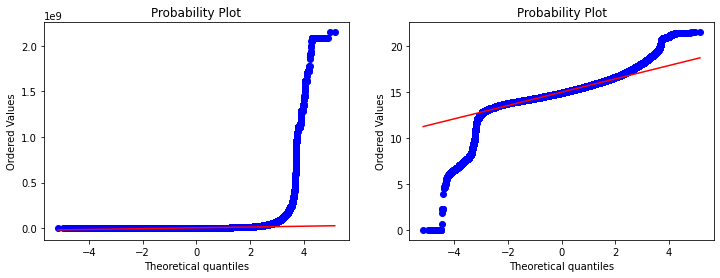

In [11]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
stats.probplot(data.price,dist="norm",plot=ax1)
ax2 = plt.subplot(122)
stats.probplot(np.log(data.price),dist="norm",plot=ax2);

<b>Теперь посмотрим на распределение признака площади в зависимости от количества комнат.</b>

In [12]:
data.groupby('rooms')[["kitchen_area","area"]].median()

,kitchen_area,area
rooms,,
-2,20.00,41.30
-1,5.00,32.47
1,10.00,37.80
2,9.50,54.00
3,10.20,72.60
4,10.80,90.00
5,16.00,147.30
6,18.00,181.00
7,20.00,212.00


<b>Есть некоторое количество записей с room = -2. Информации о том, что значит значение -2 нет. А потому стоит отфильтровать эти значения.</b>

In [13]:
data = data[data.rooms !=-2]

<b>Регионы с наибольшей разницей среднего и медианого значения цены (говорит о большим выбросах).</b>

In [14]:
data.groupby("region")["price"].agg(lambda x:np.mean(x)-np.median(x)).\
    apply(round).sort_values(ascending=False).head(5)

region
13913    10323628
3         3785349
2661      2293013
2885      1386106
9654      1163030
Name: price, dtype: int64

In [15]:
outliers_regions = data.groupby("region")["price"].agg(lambda x:np.mean(x)-np.median(x)).\
    apply(round).sort_values(ascending=False).head(5).index

In [16]:
data["date_time"] = pd.to_datetime(data['date_time'])

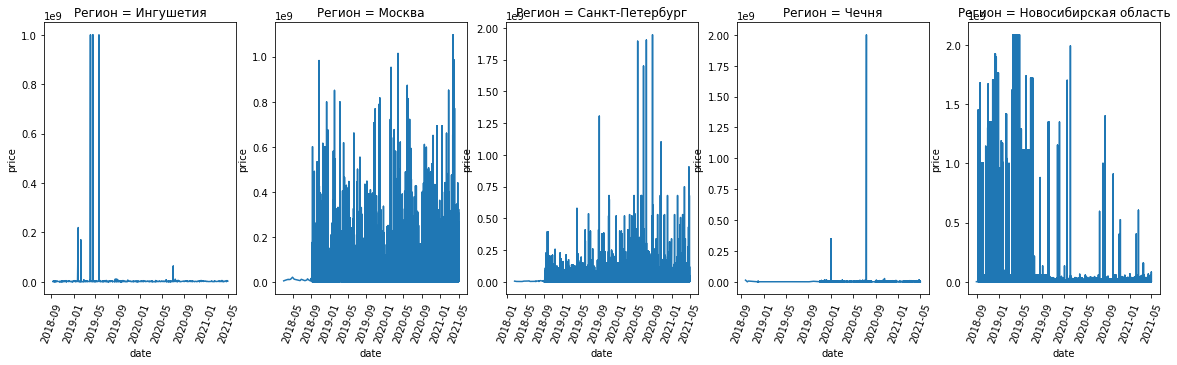

In [17]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for region, ax in zip(outliers_regions, axs):
  
    ax.plot(data[data['region'] == region]['date_time'].dt.date, 
         data[data['region'] == region]['price'])
    g = list(lat_lon_data[lat_lon_data['region'] == region].state)[0]
    ax.set_xlabel('date')
    ax.set_ylabel('price')
    ax.set_title(f'Регион = {g}')
    ax.tick_params(axis='x', rotation=70)
  

<b> Рассмотрим регионы 13913, 9654 и 6937 детальнее. </b>

In [18]:
for i in [13913, 9654, 6937]:
    reg = list(lat_lon_data[lat_lon_data['region'] == i].state)[0]
    print(f'Region = {reg, i}')
    print(data['price'][(data['region'] == i) & (data['price'] > data[data['region'] == i]['price'].mean())].value_counts().head(10))
    print()

Region = ('Ингушетия', 13913)
999999999    7
64000000     1
170000000    1
220000000    1
Name: price, dtype: int64

Region = ('Новосибирская область', 9654)
3500000    8925
4500000    5479
3800000    5262
3600000    5119
3400000    5113
4300000    4650
4000000    4568
3700000    4440
3900000    4429
4200000    4426
Name: price, dtype: int64

Region = ('Республика Крым', 6937)
5500000    65
6000000    52
6500000    40
7500000    28
5300000    26
5600000    25
5800000    25
5400000    24
6200000    24
5900000    23
Name: price, dtype: int64



<b>  В регионе 13913 мы видим явные ошибки в значении цены (999999999), которые в дальнейшем нужно будет удалить.

Регион 9654 содержит большое кол-во повторяющихся значений. Возможно, это специфика региона, либо искуственные данные.

Регион 6937 единстывенный из регионов, который действительно имеет похожие на естественные выбросы значения. </b>

<b>Стоимость жилья в зависимости от тип зданий.</b>

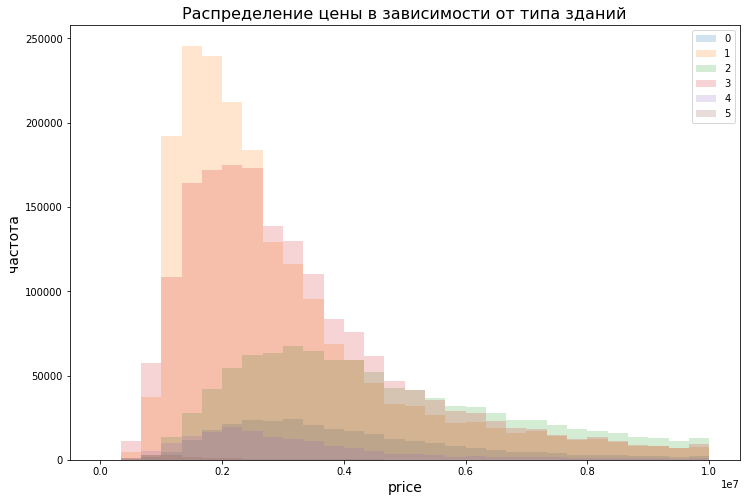

In [19]:
data.loc[data.price>500000].groupby("building_type")["price"].plot.\
    hist(range=(-1,10000000),bins=30,figsize=(12,8),alpha=0.2)
plt.title("Распределение цены в зависимости от типа зданий",fontsize=16)
plt.xlabel("price",fontsize=14)
plt.ylabel("частота",fontsize=14)
plt.legend();

<b>Стоимость недвижимости возрастает с ростом количества комнат (что очень логично).</b>

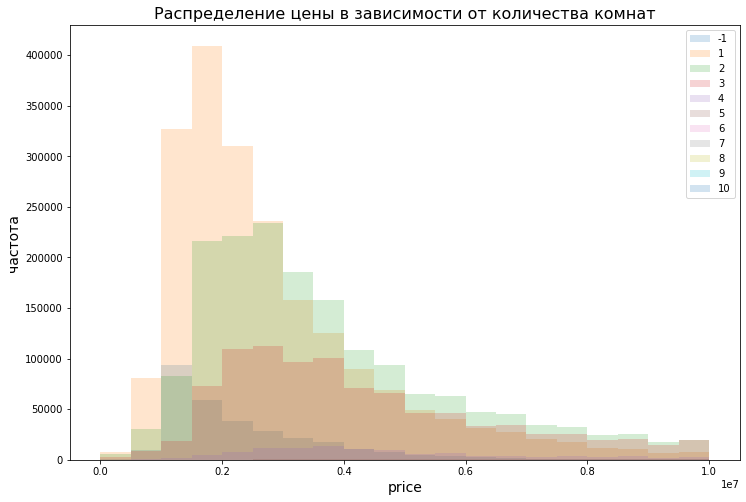

In [20]:
data.groupby("rooms")["price"].plot.hist(range=(-1,10000000),bins=20,figsize=(12,8),alpha=0.2)
plt.title("Распределение цены в зависимости от количества комнат",fontsize=16)
plt.xlabel("price",fontsize=14)
plt.ylabel("частота",fontsize=14)
plt.legend();

<b>Заметен рост стоимости из-за роста площади. Также можно заметить большой разброс данных для площади от 30 до 50 кв. метров. Скорее всего, это 1-2х комнатные квартиры, которых в датасете привалирующее число и для которых цена по регионам сильно рознится.</b>

NameError: name 'plot' is not defined

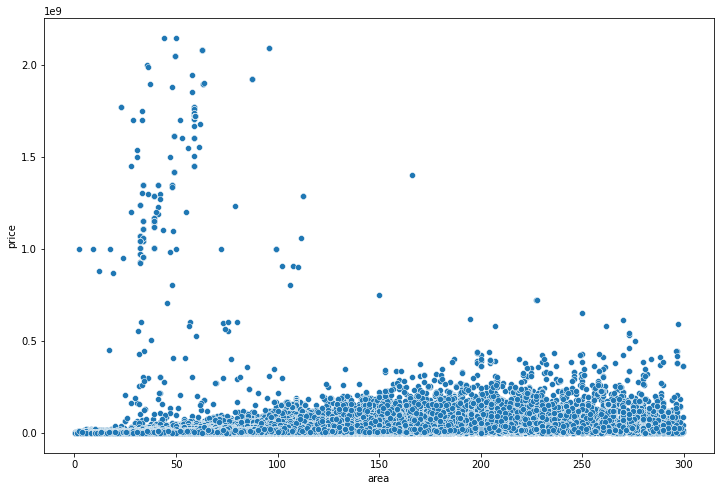

In [21]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=data.loc[data.area<300],x="area",y="price")
plot.set_xlabel("area",fontsize=16)
plot.set_ylabel("price",fontsize=16)
plot.set_title("Зависимость цены от площади",fontsize=16);

<b>Тоже самое касается и площади кухни. У которой есть некоторые фиксированные значения.</b>

In [ ]:
plt.figure(figsize=(12,8))
plot = sns.scatterplot(data=data.loc[data.kitchen_area<50],x="kitchen_area",y="price")
plot.set_xlabel("kitchen area",fontsize=16)
plot.set_ylabel("price",fontsize=16)
plot.set_title("Зависимость цены от площади кухни",fontsize=16);

<b>Теперь преобразуем date_time в timestamp и получим новые фичи (месяц и час).</b>

In [22]:
data['date_time'] = pd.to_datetime(data['date_time'])

In [23]:
data['month'] = data['date_time'].apply(lambda x:x.month)

In [34]:
data['hour'] = data["date_time"].apply(lambda x:x.hour)

<b> Интересно с чем связано такое большое варьироваие цен в течение дня</b>

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.ylabel("price")
plt.title("Зависимость цены от месяца",fontsize=14)
data.groupby("month")["price"].median().plot.bar()
plt.subplot(122)
plt.ylabel("price")
plt.title("Зависимость цены от часа",fontsize=14)
data.groupby("hour")["price"].median().plot.bar();

<b> Данных график показывает рост стоимости жилья в течение времени в случайно выбранных регионах. В таблице расчитана разница между средним значением стоимости жилья и её медианой, и наложено окно процентного изменения с предыдущим кварталом. Иначе говоря, видно как сильно меняются выбросы в регионах. </b>

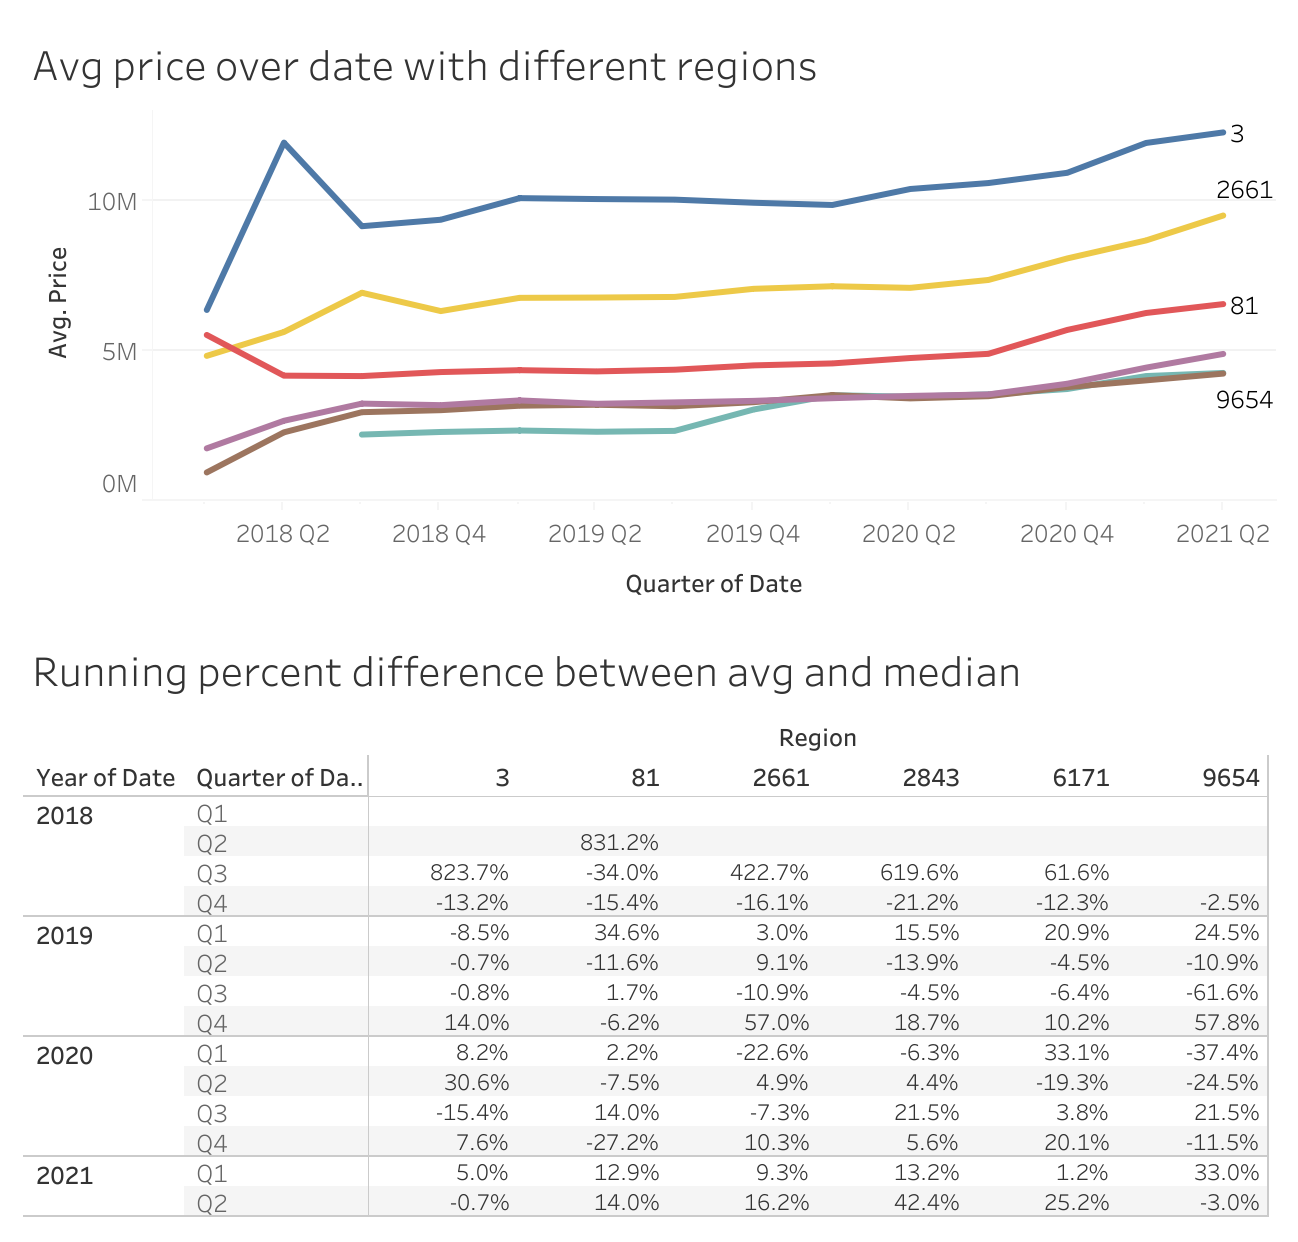

<b> В результате выполнения EDA было обнаруженно большое количество выбросов в столбах стоимости, площади и площади кухни. Также в датасете присутсвуют неправильные данные, которые попали по ошибке (системы или же человека). Был найден тренд роста цен.  </b>

<b> Интересно, что стоимость так сильно меняется в зависимости от времени выставления объясвления. </b>

In [35]:
data['quarter'] = data["date_time"].apply(lambda x:x.quarter)

In [38]:
data['year'] = data["date_time"].apply(lambda x:x.year)

In [43]:
data['day_of_week'] = data["date_time"].apply(lambda x:x.dayofweek)

In [44]:
data['week_of_year'] = data["date_time"].apply(lambda x:x.weekofyear)

In [45]:
data.corrwith(data['price'],method="spearman")

price            1.000000
geo_lat          0.281688
geo_lon         -0.477786
region          -0.458859
building_type    0.034263
level            0.263625
levels           0.375565
rooms            0.403668
area             0.513114
kitchen_area     0.449171
object_type      0.027683
month           -0.015026
hour             0.133328
quarter         -0.015372
year             0.211697
day_of_week      0.007421
week_of_year    -0.018334
dtype: float64